# Step 3 (working through the data)

Another adaptation from the suite2p notebooks that loads your data after running and curating suite2p results


In [1]:
from pathlib import Path
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
import numpy as np
import os
import tifffile
import xmltodict
import suite2p
import fastplotlib as fpl
import cv2
from ipywidgets import IntSlider, VBox

# Figure Style settings for notebook.
import matplotlib as mpl
mpl.rcParams.update({
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
    'figure.subplot.wspace': .01,
    'figure.subplot.hspace': .01,
    'figure.figsize': (9, 9),
    'ytick.major.left': False,
})
jet = mpl.cm.get_cmap('jet')
jet.set_bad(color='k')

# add this to utils
def gauss_filt(image,gSig_filt):
    #gSig_filt = np.array([7,7])
    ksize = tuple([(3 * i) // 2 * 2 + 1 for i in gSig_filt])
    ker = cv2.getGaussianKernel(ksize[0], gSig_filt[0])
    ker2D = ker.dot(ker.T)
    nz = np.nonzero(ker2D >= ker2D[:, 0].max())
    zz = np.nonzero(ker2D < ker2D[:, 0].max())
    ker2D[nz] -= ker2D[nz].mean()
    ker2D[zz] = 0
    ex = cv2.filter2D(np.array(image, dtype=np.float32),-1, ker2D, borderType=cv2.BORDER_REFLECT)
    return ex

# load local package
import sys
root_dir = os.path.split(os.getcwd())[0] # get root
utils_dir = os.path.join(root_dir,'utils') # get utils folder path
sys.path.append(utils_dir) # add it to system path (not ideal) - doing this to reduce pip installs for local lab usage
import plot_tools as fpl_tools # import movie

CaImAn package not detected
suite2p package loaded...


/var/folders/f3/11w5x6bs32gd1xc4lh41qdnr0000gp/T/ipykernel_37426/2138817087.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = mpl.cm.get_cmap('jet')


# set `output_path` to suite2p output and watch the fastplotlib plot in action!

In [2]:
# movies and associated frame rates
output_path = r'/Users/js0403/2p/A04/suite2p/plane0'
listed_data = os.listdir(output_path)

# loads in your data and automatically assigns their inputs
var_names =[]
for i in listed_data:
    if '.npy' in i:
        if 'ops' in i:
            globals()[i.split('.')[0]]=np.load(os.path.join(output_path,i),allow_pickle=True).item()
            pass
        else:
            globals()[i.split('.')[0]]=np.load(os.path.join(output_path,i),allow_pickle=True)
        var_names.append([i.split('.')[0]])

# define data_path
if len(ops['data_path'])>1 or len(ops['tiff_list'])>1:
    print("This code does not support multi-file registration")
else:
    data_path = os.path.join(ops['data_path'][0],ops['tiff_list'][0])
    print(data_path)

# prep stuff
output_op_file = np.load(Path(ops['save_path']).joinpath('ops.npy'), allow_pickle=True).item()
output_op_file.keys() == ops.keys()
stats_file = Path(ops['save_path']).joinpath('stat.npy')
iscell = np.load(Path(ops['save_path']).joinpath('iscell.npy'), allow_pickle=True)[:, 0].astype(bool)
stats = np.load(stats_file, allow_pickle=True)
stats.shape, iscell.shape

# get image object
im = suite2p.ROI.stats_dicts_to_3d_array(stats, Ly=ops['Ly'], Lx=ops['Lx'], label_id=True)
im[im == 0] = np.nan

# cell rois
cell_roi = np.nanmax(im[iscell], axis=0)
cell_roi.shape
cell_roi[~np.isnan(cell_roi)]=20

# lazy load video
images = tifffile.memmap(data_path)

#%% Watch the movie
if 'iw_movie' in locals():
    del iw_movie

iw_movie = fpl.ImageWidget(
    data=images,
    slider_dims=["t"],
    cmap="gray"
)

# add a column to overlay functional activity on structural video
struct_rgba = np.zeros((images.shape[1], images.shape[2], 4), dtype=np.float32)
struct_rgba[:, :, 1] = cell_roi
struct_rgba[..., -1] = 10
iw_movie.gridplot[0,0].add_image(struct_rgba, name='struct')
iw_movie.gridplot[0,0]
iw_movie.gridplot[0,0]["struct"].data[..., -1] = .3
#iw_movie.gridplot[0,0].add_image(cell_roi, name='struct')

# visualize the movie
iw_movie.show(sidecar=True)

/Users/js0403/2p/A04/img.tif


/var/folders/f3/11w5x6bs32gd1xc4lh41qdnr0000gp/T/ipykernel_37426/567819466.py:36: RuntimeWarning: All-NaN slice encountered
  cell_roi = np.nanmax(im[iscell], axis=0)


RFBOutputContext()

/Users/js0403/anaconda3/envs/suite2p/lib/python3.9/site-packages/fastplotlib/graphics/_features/_base.py:34: UserWarning: converting float64 array to float32
  warn(f"converting {array.dtype} array to float32")


JupyterOutputContext(children=(JupyterWgpuCanvas(), IpywidgetToolBar(children=(Button(icon='expand-arrows-alt', layout=Layout(width='auto'), style=ButtonStyle(), tooltip='auto-scale scene'), Button(icon='align-center', layout=Layout(width='auto'), style=ButtonStyle(), tooltip='auto-center scene'), ToggleButton(value=True, icon='hand-pointer', layout=Layout(width='auto'), tooltip='panzoom controller'), ToggleButton(value=True, description='1:1', layout=Layout(width='auto'), style=ToggleButtonStyle(font_weight='bold'), tooltip='maintain aspect'), Button(icon='arrow-down', layout=Layout(width='auto'), style=ButtonStyle(), tooltip='y-axis direction'), Button(icon='draw-polygon', layout=Layout(width='auto'), style=ButtonStyle(), tooltip='add PolygonSelector'), ToggleButton(value=False, icon='video', layout=Layout(width='auto'), tooltip='record'), Dropdown(description='Subplots:', layout=Layout(width='200px'), options=('(0, 0)',), value='(0, 0)'))), IpywidgetImageWidgetToolbar(children=(HBox

In [10]:
# create a slider for gSig_filt
slider_gsig_filt = IntSlider(value=3, min=1, max=33, step=1,  description="gSig_filt")

def apply_filter(frame):
    
    # read slider value
    gSig_filt = (slider_gsig_filt.value, slider_gsig_filt.value)
    
    # apply filter
    return gauss_filt(frame,gSig_filt)

# we can use frame_apply feature of `ImageWidget` to apply 
# the filter before displaying frames
funcs = {
    # data_index: function
    0: apply_filter  # filter shown on right plot, index 1
}

# input movie will be shown on left, filtered on right
iw_gs = fpl.ImageWidget(
    data=images,
    frame_apply=funcs,
    names=["movie"],
    #grid_plot_kwargs={"size": (1200, 600)},
    cmap="gnuplot2"
)

def force_update(*args):
    # kinda hacky but forces the images to update 
    # when the gSig_filt slider is moved
    iw_gs.current_index = iw_gs.current_index
    iw_gs.reset_vmin_vmax()

# reset min/max
iw_gs.reset_vmin_vmax()

# add a column to overlay functional activity on structural video
struct_rgba = np.zeros((images.shape[1], images.shape[2], 4), dtype=np.float32)
struct_rgba[:, :, 1] = cell_roi
struct_rgba[..., -1] = 10
iw_gs.gridplot[0,0].add_image(struct_rgba, name='struct')
iw_gs.gridplot[0,0]
iw_gs.gridplot[0,0]["struct"].data[..., -1] = .3

# slide updater
slider_gsig_filt.observe(force_update, "value")
VBox([iw_gs.show(), slider_gsig_filt])

RFBOutputContext()

In [41]:
iw_gs.close()

#### Results Files

In [29]:
var_names
len(Fneu[iscell][0])

6000

In [11]:
list(Path(ops['save_path']).iterdir())

[PosixPath('/Users/js0403/miniscope/PFC-Neurons/122D/AAV2/3-Syn-GCaMP8f/12_51_33/miniscopeDeviceName/suite2p/plane0/Fneu.npy'),
 PosixPath('/Users/js0403/miniscope/PFC-Neurons/122D/AAV2/3-Syn-GCaMP8f/12_51_33/miniscopeDeviceName/suite2p/plane0/spks.npy'),
 PosixPath('/Users/js0403/miniscope/PFC-Neurons/122D/AAV2/3-Syn-GCaMP8f/12_51_33/miniscopeDeviceName/suite2p/plane0/ops.npy'),
 PosixPath('/Users/js0403/miniscope/PFC-Neurons/122D/AAV2/3-Syn-GCaMP8f/12_51_33/miniscopeDeviceName/suite2p/plane0/iscell.npy'),
 PosixPath('/Users/js0403/miniscope/PFC-Neurons/122D/AAV2/3-Syn-GCaMP8f/12_51_33/miniscopeDeviceName/suite2p/plane0/F.npy'),
 PosixPath('/Users/js0403/miniscope/PFC-Neurons/122D/AAV2/3-Syn-GCaMP8f/12_51_33/miniscopeDeviceName/suite2p/plane0/stat.npy'),
 PosixPath('/Users/js0403/miniscope/PFC-Neurons/122D/AAV2/3-Syn-GCaMP8f/12_51_33/miniscopeDeviceName/suite2p/plane0/stat_orig.npy'),
 PosixPath('/Users/js0403/miniscope/PFC-Neurons/122D/AAV2/3-Syn-GCaMP8f/12_51_33/miniscopeDeviceName/

The output parameters can also be found in the "ops.npy" file.  This is especially useful when running the pipeline from the terminal or the graphical interface.  It contains the same data that is output from the python `run_s2p()` function.

In [12]:
output_op_file = np.load(Path(ops['save_path']).joinpath('ops.npy'), allow_pickle=True).item()
output_op_file.keys() == ops.keys()

True

The other files will be used for the visualizations below.

## Visualizations

### Registration

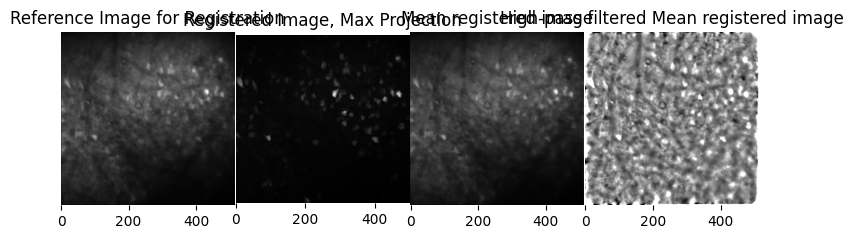

In [3]:
plt.subplot(1, 4, 1)
plt.imshow(ops['refImg'], cmap='gray', )
plt.title("Reference Image for Registration");

plt.subplot(1, 4, 2)
plt.imshow(ops['max_proj'], cmap='gray')
plt.title("Registered Image, Max Projection");

plt.subplot(1, 4, 3)
plt.imshow(ops['meanImg'], cmap='gray')
plt.title("Mean registered image")

plt.subplot(1, 4, 4)
plt.imshow(ops['meanImgE'], cmap='gray')
plt.title("High-pass filtered Mean registered image");

### Detection


In [4]:
stats_file = Path(ops['save_path']).joinpath('stat.npy')
iscell = np.load(Path(ops['save_path']).joinpath('iscell.npy'), allow_pickle=True)[:, 0].astype(bool)
stats = np.load(stats_file, allow_pickle=True)
stats.shape, iscell.shape

((340,), (340,))

In [8]:
var = np.nanmax(im, axis=0)
var[np.where(var>0)]

/var/folders/f3/11w5x6bs32gd1xc4lh41qdnr0000gp/T/ipykernel_37426/1433694692.py:1: RuntimeWarning: All-NaN slice encountered
  var = np.nanmax(im, axis=0)


array([168., 168., 168., ...,   5.,   5.,   5.])

/var/folders/f3/11w5x6bs32gd1xc4lh41qdnr0000gp/T/ipykernel_37426/829472250.py:9: RuntimeWarning: All-NaN slice encountered
  plt.imshow(np.nanmax(im, axis=0), cmap='jet')
/var/folders/f3/11w5x6bs32gd1xc4lh41qdnr0000gp/T/ipykernel_37426/829472250.py:13: RuntimeWarning: All-NaN slice encountered
  plt.imshow(np.nanmax(im[~iscell], axis=0, ), cmap='jet')
/var/folders/f3/11w5x6bs32gd1xc4lh41qdnr0000gp/T/ipykernel_37426/829472250.py:17: RuntimeWarning: All-NaN slice encountered
  plt.imshow(np.nanmax(im[iscell], axis=0), cmap='jet')


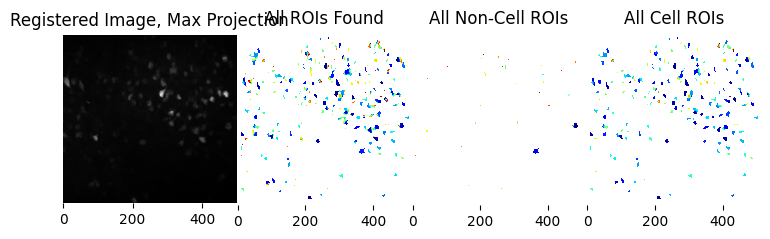

In [5]:
im = suite2p.ROI.stats_dicts_to_3d_array(stats, Ly=ops['Ly'], Lx=ops['Lx'], label_id=True)
im[im == 0] = np.nan

plt.subplot(1, 4, 1)
plt.imshow(ops['max_proj'], cmap='gray')
plt.title("Registered Image, Max Projection")

plt.subplot(1, 4, 2)
plt.imshow(np.nanmax(im, axis=0), cmap='jet')
plt.title("All ROIs Found")

plt.subplot(1, 4, 3)
plt.imshow(np.nanmax(im[~iscell], axis=0, ), cmap='jet')
plt.title("All Non-Cell ROIs")

plt.subplot(1, 4, 4)
plt.imshow(np.nanmax(im[iscell], axis=0), cmap='jet')
plt.title("All Cell ROIs");


The `cell_roi` variable is a matrix with different numerical values set for different components so that we can distinguish them. For the purposes of this visualization, set them to all be one value

/var/folders/f3/11w5x6bs32gd1xc4lh41qdnr0000gp/T/ipykernel_68805/2819684976.py:1: RuntimeWarning: All-NaN slice encountered
  cell_roi = np.nanmax(im[iscell], axis=0)


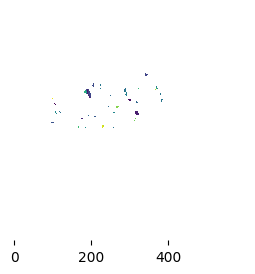

In [16]:
cell_roi = np.nanmax(im[iscell], axis=0)
plt.figure(figsize=(3,3))
plt.imshow(cell_roi)

## Extract Traces


In [17]:
f_cells = np.load(Path(ops['save_path']).joinpath('F.npy'))
f_neuropils = np.load(Path(ops['save_path']).joinpath('Fneu.npy'))
spks = np.load(Path(ops['save_path']).joinpath('spks.npy'))
f_cells.shape, f_neuropils.shape, spks.shape

((103, 6000), (103, 6000), (103, 6000))

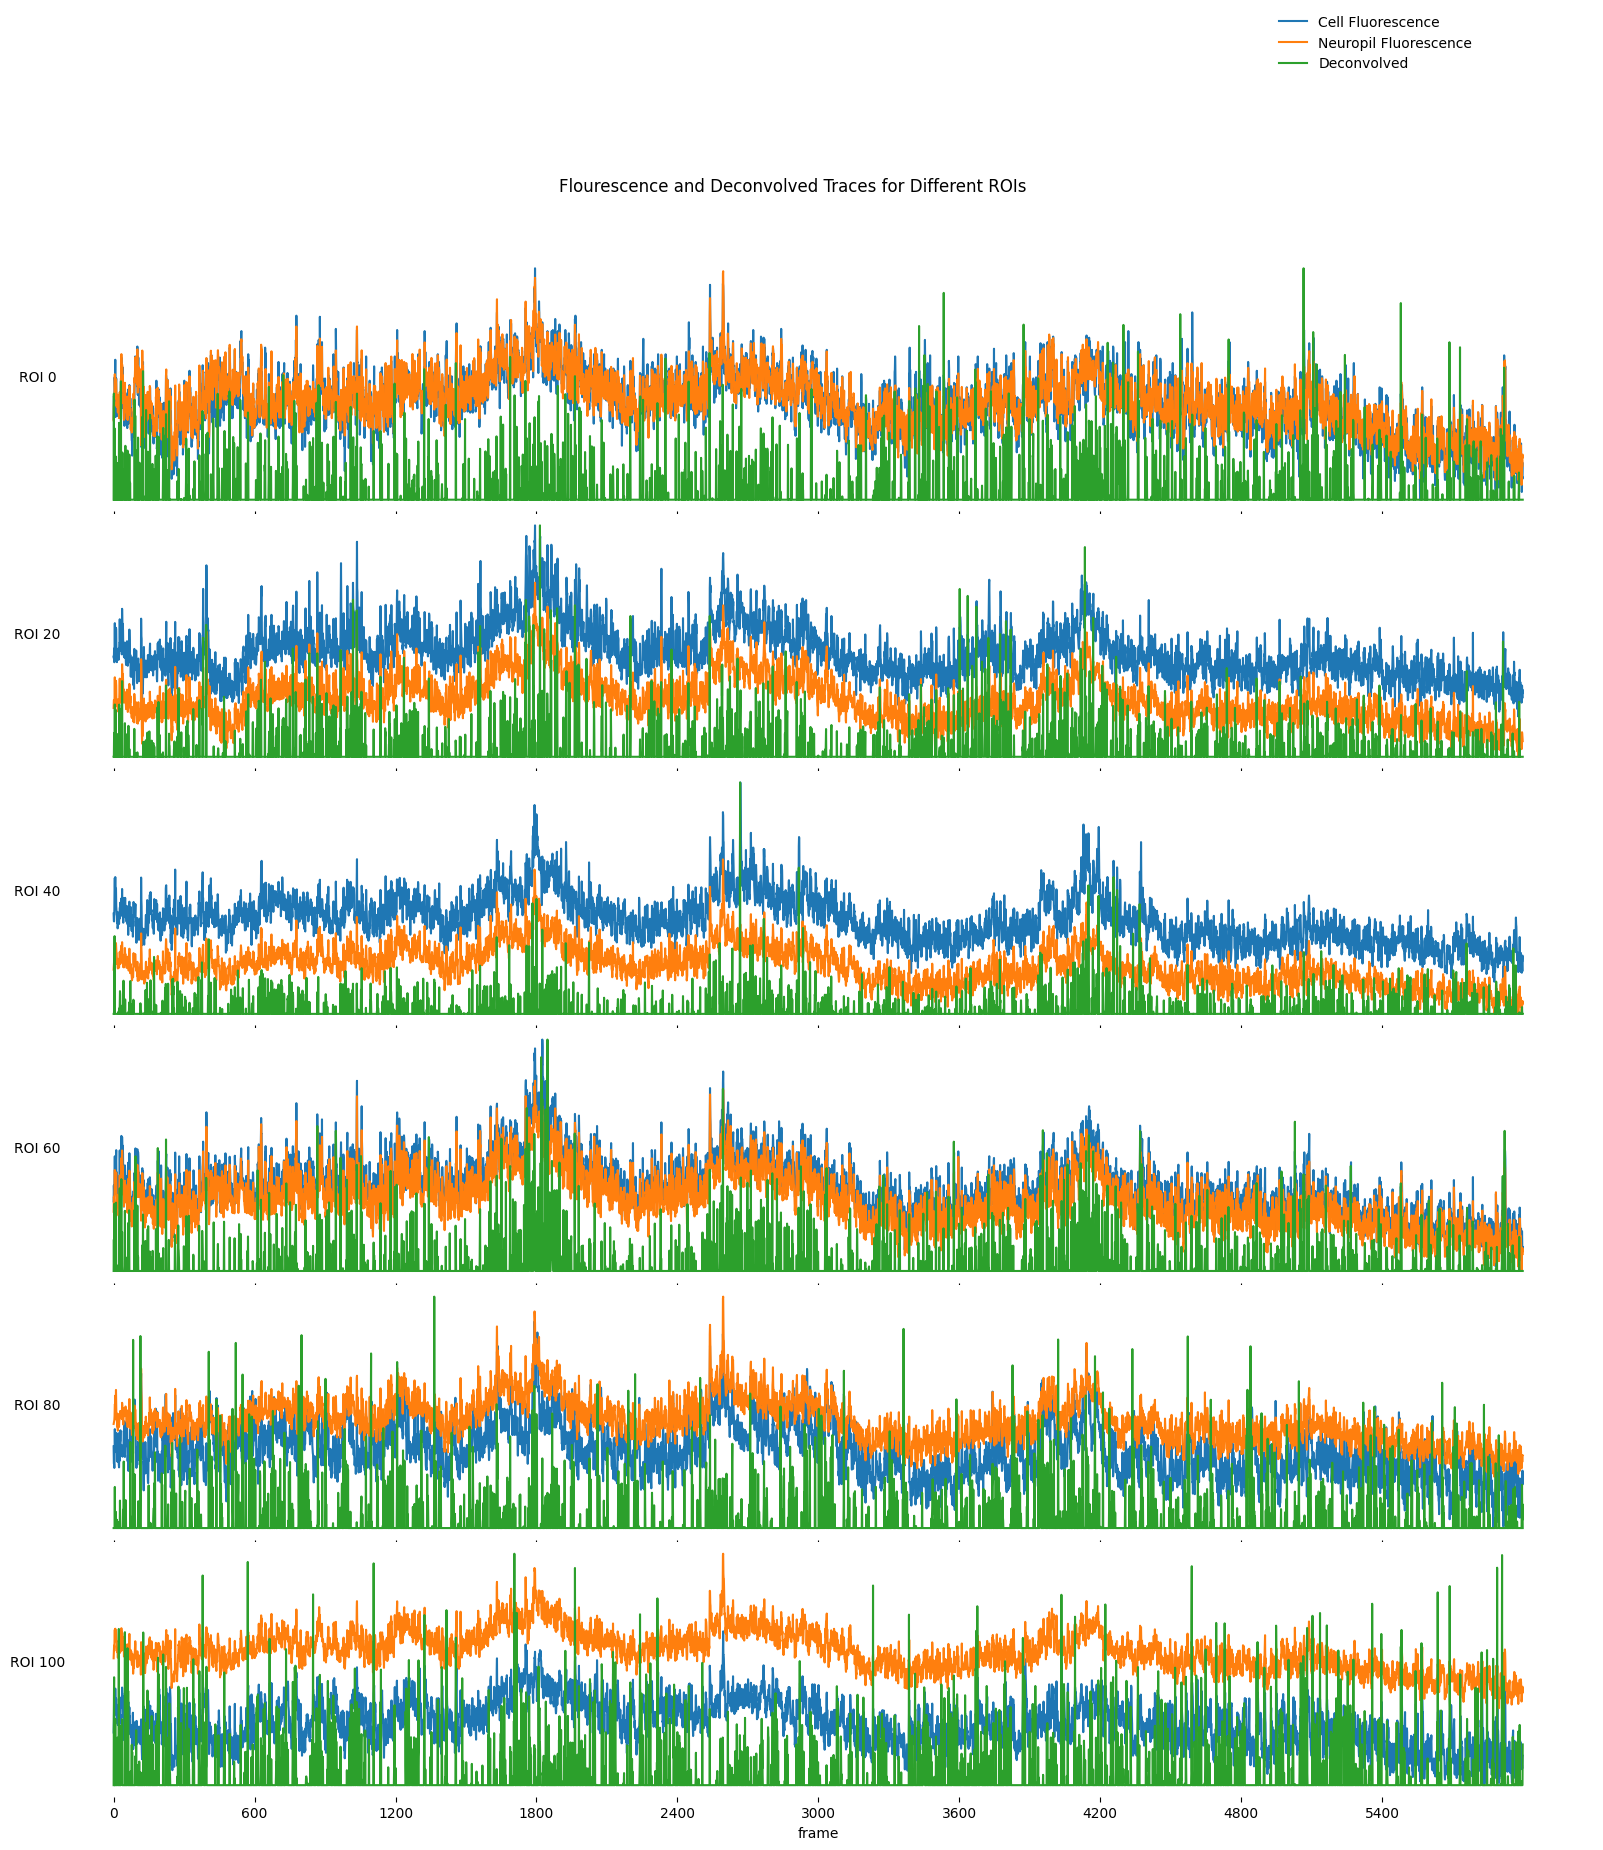

In [18]:
plt.figure(figsize=[20,20])
plt.suptitle("Flourescence and Deconvolved Traces for Different ROIs", y=0.92);
rois = np.arange(len(f_cells))[::20]
for i, roi in enumerate(rois):
    plt.subplot(len(rois), 1, i+1, )
    f = f_cells[roi]
    f_neu = f_neuropils[roi]
    sp = spks[roi]
    # Adjust spks range to match range of fluroescence traces
    fmax = np.maximum(f.max(), f_neu.max())
    fmin = np.minimum(f.min(), f_neu.min())
    frange = fmax - fmin 
    sp /= sp.max()
    sp *= frange
    plt.plot(f, label="Cell Fluorescence")
    plt.plot(f_neu, label="Neuropil Fluorescence")
    plt.plot(sp + fmin, label="Deconvolved")
    plt.xticks(np.arange(0, f_cells.shape[1], f_cells.shape[1]/10))
    plt.ylabel(f"ROI {roi}", rotation=0)
    plt.xlabel("frame")
    if i == 0:
        plt.legend(bbox_to_anchor=(0.93, 2))